In [6]:
import pandas as pd
import xgboost
import shap
from sklearn.externals import joblib

## Chargment du test set et du modèle XGBoost

In [31]:
# Chargment du modele
model = joblib.load("xgb_0.408.pkl")

# Chargement des données
test = pd.read_pickle("../data/df_test_kaggle_o_n_sk_encoded.pkl")
training = pd.read_pickle("../data/df_for_cv_o_n_sk_encoded.pkl")
test_wo_datetime = test.drop(["datetime"], axis=1)

# Verification
print(test.shape)
print(training.shape)

(6493, 17)
(10886, 18)


In [13]:
test.head()

,CN_school,CO_day,CO_holiday,CO_month,CO_season,CO_weather,CO_workingday,NN_soleil,NN_tendance_1,NN_tendance_2,NO_atemp,NO_humidity,NO_temp,NO_windspeed,datetime,CO_hour,CO_year
0,0,4,0,4,2,0,1,-64.731114,0.920373,19,11.365,56,10.66,26.0027,2011-01-20 00:00:00,0,0
1,0,4,0,4,2,0,1,-70.858731,0.920373,19,13.635,56,10.66,0.0000,2011-01-20 01:00:00,1,0
2,0,4,0,4,2,0,1,-69.313963,0.920373,19,13.635,56,10.66,0.0000,2011-01-20 02:00:00,12,0
3,0,4,0,4,2,0,1,-61.327846,0.920373,19,12.880,56,10.66,11.0014,2011-01-20 03:00:00,17,0
4,0,4,0,4,2,0,1,-50.733442,0.920373,19,12.880,56,10.66,11.0014,2011-01-20 04:00:00,18,0


In [14]:
training.head()

,CN_school,CO_day,CO_holiday,CO_month,CO_season,CO_weather,CO_workingday,NN_soleil,NN_tendance_1,NN_tendance_2,NO_atemp,NO_humidity,NO_temp,NO_windspeed,datetime,CO_hour,CO_year,count
0,0,2,1,4,2,0,0,-68.036186,0.418093,0,14.395,81,9.84,0.0,2011-01-01 00:00:00,0,0,16
1,0,2,1,4,2,0,0,-73.948688,0.418093,0,13.635,80,9.02,0.0,2011-01-01 01:00:00,1,0,40
2,0,2,1,4,2,0,0,-71.066026,0.418093,0,13.635,80,9.02,0.0,2011-01-01 02:00:00,12,0,32
3,0,2,1,4,2,0,0,-62.016308,0.418093,0,14.395,75,9.84,0.0,2011-01-01 03:00:00,17,0,13
4,0,2,1,4,2,0,0,-50.973158,0.418093,0,14.395,75,9.84,0.0,2011-01-01 04:00:00,18,0,1


In [32]:
# load JS visualization code to notebook
shap.initjs()


In [33]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_wo_datetime)

In [60]:
# L'id de l'observation
idmyobs = 3100

print("Inteprétation de la prédiction de l'observation : "+ str(test.datetime[idmyobs]))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[idmyobs,:], test_wo_datetime.iloc[idmyobs,:])

Inteprétation de la prédiction de l'observation : 2011-12-26 20:00:00


While SHAP values can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods (Tree SHAP arXiv paper). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models:
    The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue (these force plots are introduced in our Nature BME paper).

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, training)

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

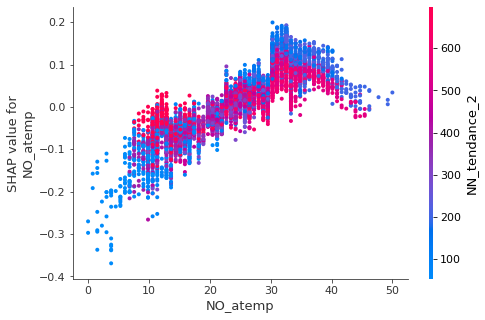

In [65]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("NO_atemp",shap_values, test_wo_datetime)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

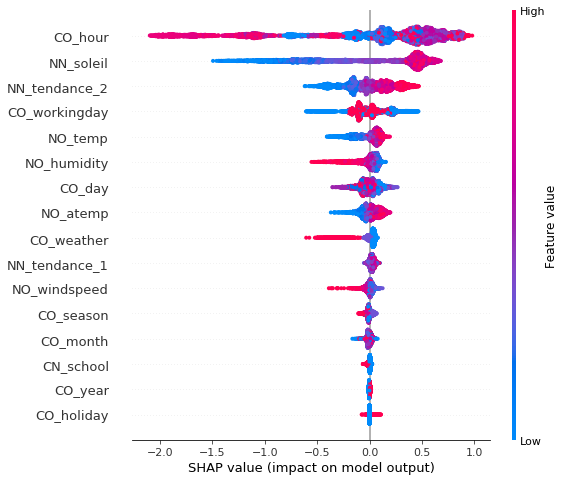

In [67]:
# summarize the effects of all the features
shap.summary_plot(shap_values, test_wo_datetime)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

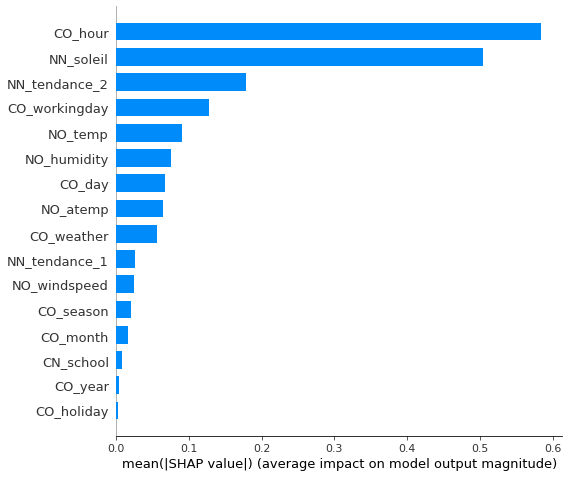

In [68]:
shap.summary_plot(shap_values, test_wo_datetime, plot_type="bar")